## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from statsmodels.stats import proportion as proptests
import statsmodels.api as sm
from scipy.stats import fisher_exact
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline


In [2]:
# load in the training data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [3]:
# Cells for you to work and document as necessary - 
# definitely feel free to add more cells as you need
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [4]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [5]:
# can try logistic regression & maybe another ML model
# remember to make dummy vars for V1, V4-V7

In [6]:
# recode Promotion
train_data['promo_cd'] = 0
train_data['promo_cd'].loc[train_data['Promotion']=='Yes'] = 1

/home/umahp/data_science/dsenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
# make sure it worked
n_promo = train_data[train_data['Promotion']=='Yes']['Promotion'].count()
display(n_promo)
display(train_data['promo_cd'].sum())

42364

42364

Look at whether the groups are effectively randomized

In [8]:
# are promo groups balanced?
size = train_data.shape[0]
prop1 = n_promo/size
display(prop1)

0.5011474672912675

In [9]:
# test it
p_exact = proptests.binom_test(n_promo, size) # defaults to null p = 0.5 & two-sided
display(p_exact)

0.5068143028294426

Proportions receiving or not receiving the promotion are statistically similar.  
Does receipt of promotion increase likelihood of purchase?

In [10]:
# does the promotion lead to purchases? (2x2 contingency table)
# fisher exact test for 2x2 table
count11 = train_data[train_data['promo_cd']==1]['purchase'].sum()
count01 = train_data[train_data['promo_cd']==0]['purchase'].sum()
count10 = train_data[train_data['promo_cd']==1]['purchase'].count()-count11
count00 = train_data[train_data['promo_cd']==0]['purchase'].count()-count01
table = [[count00, count10], [count01, count11]]
prop_no = count01/(count00+count01)
prop_yes = count11/(count10+count11)
display(table, prop_no, prop_yes)
p_stat = fisher_exact(table, alternative='greater')
display(p_stat)

[[41851, 41643], [319, 721]]

0.007564619397676073

0.017019167217448776

(2.2714773590145283, 1.0678851684503813e-36)

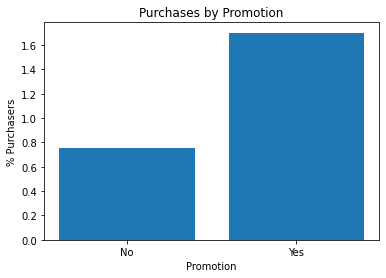

In [11]:
ind = [1.0, 2.0]
plt.bar(ind, [100.0*prop_no, 100.0*prop_yes])
plt.xticks(ind, ['No', 'Yes'])
plt.xlabel('Promotion')
plt.ylabel('% Purchasers')
plt.title('Purchases by Promotion');

Odd ratio is 2.27, p-value basically zero. Receiving promotion tends to lead to a purchase.

Check the association between V1-V7 and purchases

Calculate the net incremental revenue

In [12]:
NIR = 10.0*count11 - 0.15*(count11+count10) - 10.0*count01
print(NIR)

-2334.5999999999995


So it actually is a net loss b/c so many folks in the treatment group didn't purchase.

See what incremental response rate looks like

In [13]:
IRR = prop_yes - prop_no
print(IRR)

0.009454547819772702


A tiny increase in proportion in the treatment group. But significant since the control is so small (0.0075)

In [14]:
# save it in case I screw this up
data_bu = train_data.copy()

In [15]:
# make dummies for the categorical variables
# preparatory steps
train_data['intercept'] = 1 # needs to be manually added for statsmodels regression
train_data[['V1_0', 'V1_1', 'V1_2', 'V1_3']] =pd.get_dummies(train_data['V1'])
train_data[['V4_1', 'V4_2']] =pd.get_dummies(train_data['V4'])
train_data[['V5_1', 'V5_2', 'V5_3', 'V5_4']] =pd.get_dummies(train_data['V5'])
train_data[['V6_1', 'V6_2', 'V6_3', 'V6_4']] =pd.get_dummies(train_data['V6'])
train_data[['V7_1', 'V7_2']] =pd.get_dummies(train_data['V7'])

In [16]:
display(train_data.head())

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,...,V5_1,V5_2,V5_3,V5_4,V6_1,V6_2,V6_3,V6_4,V7_1,V7_2
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,...,1,0,0,0,0,0,1,0,0,1
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,...,0,0,1,0,0,1,0,0,0,1
2,4,No,0,2,30.431659,0.133583,1,1,4,2,...,1,0,0,0,0,0,0,1,0,1
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,...,1,0,0,0,0,0,0,1,0,1
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2,...,1,0,0,0,0,1,0,0,0,1


To optimize the metrics the way the test evaluation is set up, I'm going to use the outcome of people who made a purchase **after** getting the promotion.  Based on the way they have us calculating IRR and NIRR on the test data, identifying members of that group should and sending them promotions should maximize the outcomes.

In [17]:
train_data['promo+purch'] = train_data['purchase']*train_data['promo_cd']
display(train_data['promo+purch'].value_counts())

0    83813
1      721
Name: promo+purch, dtype: int64

Since the instructions seem to imply we shouldn't peek at the test data til we have the final model, make a train-test split of this dataset. The `stratify` option is to keep the same proportions of the outcome variable in the train & test sets.

In [18]:
# split data; leave out a reference category for each dummy variable
# use stratification to maintain same 0/1 ratio 
X_train, X_test, y_train, y_test = train_test_split(train_data[['purchase', 'promo_cd','intercept', 'V1_1', 'V1_2', 'V1_3', 'V2',\
                                                               'V3', 'V4_2', 'V5_2', 'V5_3', 'V5_4', \
                                                               'V6_2', 'V6_3', 'V6_4', 'V7_2']],\
                                                                train_data['promo+purch'], train_size = 0.667,\
                                                                stratify = train_data['promo+purch'])

Do graphical exploration and run a univariate logistic regression model for each variable

In [54]:
v1_promopurch = train_data.groupby(['V1'], as_index=False)[['promo+purch']].mean()
v1_promopurch['promo+purch'] = v1_promopurch['promo+purch']*100.0
display(v1_promopurch)

,V1,promo+purch
0,0,0.922353
1,1,0.796687
2,2,0.955454
3,3,0.646673


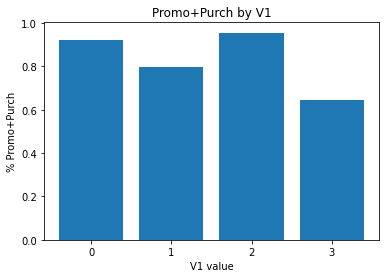

In [55]:
ind = [1.0, 2.0, 3.0, 4.0]
plt.bar(ind, v1_promopurch['promo+purch'])
plt.xticks(ind, ['0', '1', '2', '3'])
plt.xlabel('V1 value')
plt.ylabel('% Promo+Purch')
plt.title('Promo+Purch by V1');

In [56]:
log1 = sm.Logit(y_train, X_train[['intercept','V1_1', 'V1_2', 'V1_3']])
logr1 = log1.fit()
logr1.summary2()

Optimization terminated successfully.
         Current function value: 0.049036
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.002    
Dependent Variable: promo+purch      AIC:              5537.7380
Date:               2021-05-22 16:13 BIC:              5573.4978
No. Observations:   56384            Log-Likelihood:   -2764.9  
Df Model:           3                LL-Null:          -2770.5  
Df Residuals:       56380            LLR p-value:      0.010763 
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     9.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
intercept   -4.7066    0.1256  -37.4836  0.0000  -4.9527  -4.4605
V1_1        -0.1249    0.1477   -0.8462  0.3974  -0.4143   0.1644
V1_2         0.0958    0.1436    0.6674  0.5045  -0.1856   0.3773
V1_3        -0.4040    0.1993   -2.0270  0.0427  -0.7946  -0.0134
================================================================

"""

V1 = 3 is associated with fewer purchases with promotion

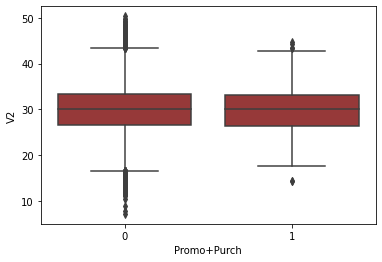

In [57]:
sb.boxplot(data=train_data, x='promo+purch', y='V2', color='brown')
plt.ylabel('V2')
plt.xlabel('Promo+Purch');

In [58]:
log1 = sm.Logit(y_train, X_train[['intercept','V2']])
logr1 = log1.fit()
logr1.summary2()

Optimization terminated successfully.
         Current function value: 0.049115
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.000    
Dependent Variable: promo+purch      AIC:              5542.5695
Date:               2021-05-22 16:13 BIC:              5560.4493
No. Observations:   56384            Log-Likelihood:   -2769.3  
Df Model:           1                LL-Null:          -2770.5  
Df Residuals:       56382            LLR p-value:      0.12495  
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     9.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
intercept   -4.3380    0.2743  -15.8133  0.0000  -4.8757  -3.8004
V2          -0.0140    0.0091   -1.5345  0.1249  -0.0319   0.0039
================================================================

"""

V2 does not appear to influencing purchase after promotion

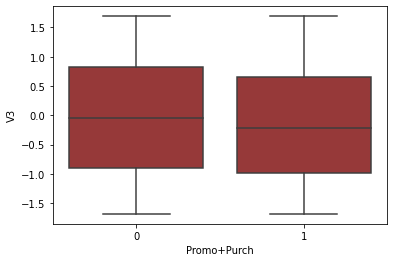

In [59]:
sb.boxplot(data=train_data, x='promo+purch', y='V3', color='brown')
plt.ylabel('V3')
plt.xlabel('Promo+Purch');

In [60]:
log1 = sm.Logit(y_train, X_train[['intercept','V3']])
logr1 = log1.fit()
logr1.summary2()

Optimization terminated successfully.
         Current function value: 0.049065
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.001    
Dependent Variable: promo+purch      AIC:              5536.9603
Date:               2021-05-22 16:14 BIC:              5554.8402
No. Observations:   56384            Log-Likelihood:   -2766.5  
Df Model:           1                LL-Null:          -2770.5  
Df Residuals:       56382            LLR p-value:      0.0047735
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     9.0000                                      
-----------------------------------------------------------------
            Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
intercept  -4.7637    0.0462  -103.1907  0.0000  -4.8542  -4.6732
V3         -0.1294    0.0460    -2.8147  0.0049  -0.2196  -0.0393
================================================================

"""

A negative value of V3 influences purchase after promotion.

In [61]:
v4_promopurch = train_data.groupby(['V4'], as_index=False)[['promo+purch']].mean()
v4_promopurch['promo+purch'] = v4_promopurch['promo+purch']*100.0
display(v4_promopurch)

,V4,promo+purch
0,1,0.350761
1,2,1.089643


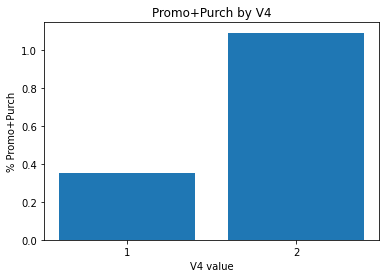

In [62]:
ind = [1.0, 2.0]
plt.bar(ind, v4_promopurch['promo+purch'])
plt.xticks(ind, ['1', '2'])
plt.xlabel('V4 value')
plt.ylabel('% Promo+Purch')
plt.title('Promo+Purch by V4');

In [63]:
log1 = sm.Logit(y_train, X_train[['intercept','V4_2']])
logr1 = log1.fit()
logr1.summary2()

Optimization terminated successfully.
         Current function value: 0.048322
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.017     
Dependent Variable: promo+purch      AIC:              5453.1927 
Date:               2021-05-22 16:16 BIC:              5471.0726 
No. Observations:   56384            Log-Likelihood:   -2724.6   
Df Model:           1                LL-Null:          -2770.5   
Df Residuals:       56382            LLR p-value:      9.9300e-22
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     10.0000                                      
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
intercept    -5.6412    0.1252  -45.0496  0.0000  -5.8866  -5.3958
V4_2          1.1324    0.1346    8.4160  0.0000   0.8687   1.3961
=================================================================

"""

V4 influences purchases, with a value of 2 associated with more.

In [64]:
v5_promopurch = train_data.groupby(['V5'], as_index=False)[['promo+purch']].mean()
v5_promopurch['promo+purch'] = v5_promopurch['promo+purch']*100.0
display(v5_promopurch)

,V5,promo+purch
0,1,1.025175
1,2,0.512886
2,3,1.099472
3,4,0.829635


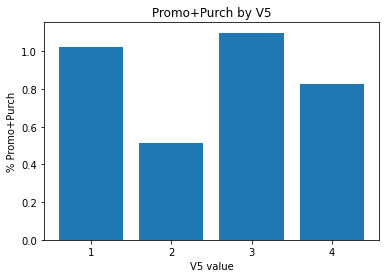

In [65]:
ind = [1.0, 2.0, 3.0, 4.0]
plt.bar(ind, v5_promopurch['promo+purch'])
plt.xticks(ind, ['1', '2', '3', '4'])
plt.xlabel('V5 value')
plt.ylabel('% Promo+Purch')
plt.title('Promo+Purch by V5');

In [66]:
log1 = sm.Logit(y_train, X_train[['intercept','V5_2', 'V5_3', 'V5_4']])
logr1 = log1.fit()
logr1.summary2()

Optimization terminated successfully.
         Current function value: 0.048757
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.008     
Dependent Variable: promo+purch      AIC:              5506.2116 
Date:               2021-05-22 16:18 BIC:              5541.9713 
No. Observations:   56384            Log-Likelihood:   -2749.1   
Df Model:           3                LL-Null:          -2770.5   
Df Residuals:       56380            LLR p-value:      2.8330e-09
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     9.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
intercept    -4.5797    0.0986  -46.4658  0.0000  -4.7728  -4.3865
V5_2         -0.6181    0.1359   -4.5497  0.0000  -0.8844  -0.3518
V5_3          0.0693    0.1182    0.5858  0.5580  -0.1625   0.3010
V5_4         -0.3353    0.2236   -1.4996  0.1337  -0.7736   0.1029
=================================================================

"""

A V5 value of 2 is associated with fewer purchases after promotion.

In [67]:
v6_promopurch = train_data.groupby(['V6'], as_index=False)[['promo+purch']].mean()
v6_promopurch['promo+purch'] = v6_promopurch['promo+purch']*100.0
display(v6_promopurch)

,V6,promo+purch
0,1,0.889375
1,2,0.803935
2,3,0.896819
3,4,0.821685


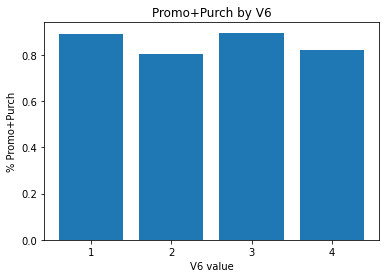

In [68]:
ind = [1.0, 2.0, 3.0, 4.0]
plt.bar(ind, v6_promopurch['promo+purch'])
plt.xticks(ind, ['1', '2', '3', '4'])
plt.xlabel('V6 value')
plt.ylabel('% Promo+Purch')
plt.title('Promo+Purch by V6');

In [69]:
log1 = sm.Logit(y_train, X_train[['intercept','V6_2', 'V6_3', 'V6_4']])
logr1 = log1.fit()
logr1.summary2()

Optimization terminated successfully.
         Current function value: 0.049105
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.001    
Dependent Variable: promo+purch      AIC:              5545.5259
Date:               2021-05-22 16:19 BIC:              5581.2857
No. Observations:   56384            Log-Likelihood:   -2768.8  
Df Model:           3                LL-Null:          -2770.5  
Df Residuals:       56380            LLR p-value:      0.33428  
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     9.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
intercept   -4.6302    0.0862  -53.7358  0.0000  -4.7991  -4.4613
V6_2        -0.1479    0.1267   -1.1676  0.2430  -0.3962   0.1004
V6_3        -0.2330    0.1291   -1.8046  0.0711  -0.4861   0.0201
V6_4        -0.1332    0.1261   -1.0561  0.2909  -0.3803   0.1140
================================================================

"""

V6 is not associated with purchasing decisions.

In [70]:
v7_promopurch = train_data.groupby(['V7'], as_index=False)[['promo+purch']].mean()
v7_promopurch['promo+purch'] = v7_promopurch['promo+purch']*100.0
display(v7_promopurch)

,V7,promo+purch
0,1,0.904152
1,2,0.831128


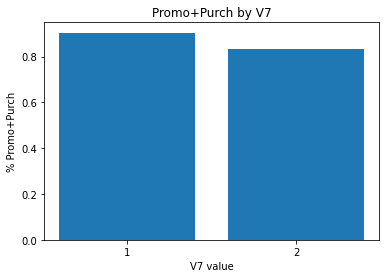

In [71]:
ind = [1.0, 2.0]
plt.bar(ind, v7_promopurch['promo+purch'])
plt.xticks(ind, ['1', '2'])
plt.xlabel('V7 value')
plt.ylabel('% Promo+Purch')
plt.title('Promo+Purch by V7');

In [72]:
log1 = sm.Logit(y_train, X_train[['intercept','V7_2']])
logr1 = log1.fit()
logr1.summary2()

Optimization terminated successfully.
         Current function value: 0.049134
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.000    
Dependent Variable: promo+purch      AIC:              5544.7389
Date:               2021-05-22 16:20 BIC:              5562.6188
No. Observations:   56384            Log-Likelihood:   -2770.4  
Df Model:           1                LL-Null:          -2770.5  
Df Residuals:       56382            LLR p-value:      0.66739  
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     9.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
intercept   -4.7257    0.0826  -57.2376  0.0000  -4.8875  -4.5639
V7_2        -0.0428    0.0992   -0.4309  0.6665  -0.2372   0.1517
================================================================

"""

V7 is not associated with purchasing decisions.

Make a multivariate logistic regression model to see if all of the variables remain significant in each other's presence.

In [90]:
log1 = sm.Logit(y_train, X_train[['intercept','V1_3', 'V3', 'V4_2', 'V5_2']])
logr1 = log1.fit()
logr1.summary2()

Optimization terminated successfully.
         Current function value: 0.047847
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.026     
Dependent Variable: promo+purch      AIC:              5405.6489 
Date:               2021-05-22 16:27 BIC:              5450.3486 
No. Observations:   56384            Log-Likelihood:   -2697.8   
Df Model:           4                LL-Null:          -2770.5   
Df Residuals:       56379            LLR p-value:      2.0945e-30
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     10.0000                                      
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
intercept    -5.4174    0.1287  -42.0826  0.0000  -5.6697  -5.1651
V1_3         -0.4018    0.1622   -2.4776  0.0132  -0.7196  -0.0839
V3           -0.1323    0.0461   -2.8713  0.0041  -0.2226  -0.0420
V4_2          1.1349    0.1346    8.4320  0.0000   0.8711   1.3987
V5_2         -0.6339    0.1073   -5.9063  0.0000  -0.8443  -0.4236
=================================================================

"""

Make a multivariate logistic regression model. 
Since the data are sparse, will want to start with weighted logistic regression.
Can't find a way to do that with the statsmodel version, so will use sklearn instead.
The `ColumnTransformer` step is to scale V3 to mean 1, sd 0 for use an SVM and other scale-dependent models.  
What I'm doing here is preliminary feature selection -- just keeping the variables that were significant in the univariate analysis. For the categorical variables, only the dummy variable that was significant is retained, since all the other dummies are effectively equivalent.  
For example, for V5, only the dummy variable for the value `2` had a significant regression coefficient. I dropped the dummy variables for `1`, `3`, and `4`. The comparison this is making is `V5 = 2` versus `V5 = 1, 3, or 4`.

In [92]:
# just keep the variables that were singificant on univariate analysis
X_train2 = X_train[['V1_3', 'V3', 'V4_2', 'V5_2']]
X_test2 = X_test[['V1_3', 'V3', 'V4_2', 'V5_2']]
# create a set with V3 scaled for SVM
ct = ColumnTransformer([("std", StandardScaler(), ['V3'])], remainder = 'passthrough')
X_train3 = ct.fit_transform(X_train2)
X_test3 = ct.fit_transform(X_test2)
display(X_train2.head())
display(X_train3[0:5,:])
display(X_test2.head())
display(X_test3[0:5,:])

,V1_3,V3,V4_2,V5_2
42450,1,-0.732194,1,1
39436,0,-0.385883,1,0
49424,0,-0.126150,0,0
17107,0,0.133583,1,0
56521,0,0.220161,1,1


array([[-0.73179378,  1.        ,  1.        ,  1.        ],
       [-0.38584589,  0.        ,  1.        ,  0.        ],
       [-0.12638507,  0.        ,  0.        ,  0.        ],
       [ 0.13307586,  0.        ,  1.        ,  0.        ],
       [ 0.21956282,  0.        ,  1.        ,  1.        ]])

,V1_3,V3,V4_2,V5_2
51895,0,0.220161,0,1
51955,1,0.653050,1,0
11131,0,-0.385883,1,0
56386,0,-0.299306,1,0
5865,0,-0.039572,1,1


array([[ 0.22047253,  0.        ,  0.        ,  1.        ],
       [ 0.65364963,  1.        ,  1.        ,  0.        ],
       [-0.3859754 ,  0.        ,  1.        ,  0.        ],
       [-0.29933997,  0.        ,  1.        ,  0.        ],
       [-0.03943377,  0.        ,  1.        ,  1.        ]])

These two functions just return various scores for each model. The first gets the conventional scores (precision, recall, accuracy, area under the ROC) and the confusion matrix. The second returns values for the specific metrics Starbucks is interested in (NIR, IRR), using only customers predicted to receive a promotion.

In [74]:
def get_scores(y_test, y_pred):
    '''
    get scores for the fitted models
    inputs:
    y_test = true labels
    y_preds = model predictions
    
    returns: none
    '''
    
    cm = confusion_matrix(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    print('confusion matrix:\n', cm)
    print('precision: {:.5f}; recall: {:.5f}, accuracy: {:.5f}'.format(prec, rec, acc))
    print('roc_auc: {:.5f}'.format(auc))
    
    return

In [75]:
def score2(df, promo_pred_col = 'promo_cd'):
    '''
    Calculate the scoring metrics defined by Starbucks
    input:
    df = dataframe of features **only** for those we predicted should receive a promotion
    promo_pred_col : the column categorizing whether or not the subject received a promotion 
                     instead of using the original "Promotion", I used its binary recode (0 = No, 1 = Yes)
    '''
    n_treat       = df.loc[df[promo_pred_col] == 1,:].shape[0]
    n_control     = df.loc[df[promo_pred_col] == 0,:].shape[0]
    n_treat_purch = df.loc[df[promo_pred_col] == 1, 'purchase'].sum()
    n_ctrl_purch  = df.loc[df[promo_pred_col] == 0, 'purchase'].sum()
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch
    print('IRR: {:.5f}; NIR: {:.5f}'.format(irr, nir))
    
    return

`class_weight = balanced` will weight the samples inversely proportionally to their prevalence in the data. So here, `promo+purch = 1` will be heavily weighted due to its rarity. Helps to account for the imbalance in the data.

Here's an example of what happens if we don't use a strategy like class weights or over/under-sampling to account for the imbalance. I did this the first go-round with these data.

In [93]:
log_mod_unwt = LogisticRegression(max_iter = 200)
log_mod_unwt.fit(X_train2, y_train)
y_pred_unwt = log_mod_unwt.predict(X_test2)
get_scores(y_test, y_pred_unwt)

confusion matrix:
 [[27910     0]
 [  240     0]]
precision: 0.00000; recall: 0.00000, accuracy: 0.99147
roc_auc: 0.50000


/home/umahp/data_science/dsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With an imbalanced dataset like this, the classic mistake (which I made) would be to look only at the accuracy, or at the p-value for the regression coefficients, and think the model is great. However, as you can see, it completely ignores the minority class. Since that's the class we're interested in, the model is effective useless. We can't even calculate NIR & IRR because we haven't predicted that **anyone** should receive a promotion.

So now let's see what it looks like when we turn on the class weighting:

In [94]:
log_mod = LogisticRegression(max_iter = 200, class_weight = 'balanced')
log_mod.fit(X_train2, y_train)
y_pred1 = log_mod.predict(X_test2)
get_scores(y_test, y_pred1)

confusion matrix:
 [[15322 12588]
 [   64   176]]
precision: 0.01379; recall: 0.73333, accuracy: 0.55055
roc_auc: 0.64116


In [96]:
# mask X_test for only those predicted to receive a promotion
score_df = X_test.iloc[np.where(y_pred1 == 1)]

In [97]:
score2(score_df)

IRR: 0.02040; NIR: 343.45000


There is lots of mis-classification, with tons of false positives, but at least the model is predicting some customers in the promotion group. Let's see if we can do better.

See if interaction terms improve the model.

In [98]:
X_trn_intr = X_train2.copy()
X_trn_intr['V13xV3'] = X_trn_intr['V1_3'] * X_trn_intr['V3']
X_trn_intr['V13x42'] = X_trn_intr['V1_3'] * X_trn_intr['V4_2']
X_trn_intr['V13x52'] = X_trn_intr['V1_3'] * X_trn_intr['V5_2']
X_trn_intr['V3x42'] = X_trn_intr['V3'] * X_trn_intr['V4_2']
X_trn_intr['V3x52'] = X_trn_intr['V3'] * X_trn_intr['V5_2']
X_trn_intr['V42x52'] = X_trn_intr['V4_2'] * X_trn_intr['V5_2']

In [99]:
X_tst_intr = X_test2.copy()
X_tst_intr['V13xV3'] = X_tst_intr['V1_3'] * X_tst_intr['V3']
X_tst_intr['V13x42'] = X_tst_intr['V1_3'] * X_tst_intr['V4_2']
X_tst_intr['V13x52'] = X_tst_intr['V1_3'] * X_tst_intr['V5_2']
X_tst_intr['V3x42'] = X_tst_intr['V3'] * X_tst_intr['V4_2']
X_tst_intr['V3x52'] = X_tst_intr['V3'] * X_tst_intr['V5_2']
X_tst_intr['V42x52'] = X_tst_intr['V4_2'] * X_tst_intr['V5_2']

In [100]:
display(X_trn_intr.head())
display(X_tst_intr.head())

,V1_3,V3,V4_2,V5_2,V13xV3,V13x42,V13x52,V3x42,V3x52,V42x52
42450,1,-0.732194,1,1,-0.732194,1,1,-0.732194,-0.732194,1
39436,0,-0.385883,1,0,-0.000000,0,0,-0.385883,-0.000000,0
49424,0,-0.126150,0,0,-0.000000,0,0,-0.000000,-0.000000,0
17107,0,0.133583,1,0,0.000000,0,0,0.133583,0.000000,0
56521,0,0.220161,1,1,0.000000,0,0,0.220161,0.220161,1


,V1_3,V3,V4_2,V5_2,V13xV3,V13x42,V13x52,V3x42,V3x52,V42x52
51895,0,0.220161,0,1,0.00000,0,0,0.000000,0.220161,0
51955,1,0.653050,1,0,0.65305,1,0,0.653050,0.000000,0
11131,0,-0.385883,1,0,-0.00000,0,0,-0.385883,-0.000000,0
56386,0,-0.299306,1,0,-0.00000,0,0,-0.299306,-0.000000,0
5865,0,-0.039572,1,1,-0.00000,0,0,-0.039572,-0.039572,1


In [101]:
# model including the 6 interaction terms
log_mod2 = LogisticRegression(max_iter = 200, class_weight = 'balanced')
log_mod2.fit(X_trn_intr, y_train)
y_pred2 = log_mod2.predict(X_tst_intr)
get_scores(y_test, y_pred2)
score_df = X_test.iloc[np.where(y_pred2 == 1)] 
score2(score_df)

confusion matrix:
 [[14849 13061]
 [   59   181]]
precision: 0.01367; recall: 0.75417, accuracy: 0.53393
roc_auc: 0.64310
IRR: 0.02022; NIR: 346.25000


IRR is slightly worse, NIR is slightly better. Precision is a little worse. Will not use the interactions since minimal contribution and may lead to overfitting since adds 6 more variables.

Try cross-validation tuning of the C-parameter. Will use model without interactions. Use precision as the score metric to see if can minimize the false positives.

In [102]:
log_modcv = LogisticRegressionCV(max_iter = 200, scoring = 'precision', class_weight='balanced', n_jobs = -1)
log_modcv.fit(X_train2, y_train)
y_predlogcv = log_modcv.predict(X_test2)
print('LogRegCV optimal C:', log_modcv.C_)

LogRegCV optimal C: [0.00077426]


In [103]:
get_scores(y_test, y_predlogcv)
score_df = X_test.iloc[np.where(y_predlogcv == 1)] 
score2(score_df)

confusion matrix:
 [[14887 13023]
 [   62   178]]
precision: 0.01348; recall: 0.74167, accuracy: 0.53517
roc_auc: 0.63753
IRR: 0.01963; NIR: 307.90000


Worse than the un-tuned model. 

Try a machine-learning model. Will start with SVM.  
Will use the data without the interactions since they didn't seem to help.
Again, will use `balanced` class weight to adjust for the imbalance.
I did a lot of manual tuning on the parameters and what's below was my best for `C` and `gamma`. 

In [104]:
# in exploratory analyses, these were the best manually tuned params for SVC
clf = SVC(class_weight='balanced', C=5, gamma=2)
clf.fit(X_train3, y_train) # use the set with V3 normalized
y_pred3 = clf.predict(X_test3) # normalized V3 again

In [105]:
get_scores(y_test, y_pred3)
score_df = X_test.iloc[np.where(y_pred3 == 1)] 
score2(score_df)

confusion matrix:
 [[14102 13808]
 [   60   180]]
precision: 0.01287; recall: 0.75000, accuracy: 0.50735
roc_auc: 0.62763
IRR: 0.01849; NIR: 247.75000


This is slightly worse than logistic regression, although hyperparameters could probably be more finely tuned.

Will try some tuning with `GridSearchCV`.  
The narrow range here is after trying other experiments with wider ranges that didn't improve performance.

In [106]:
# best manually tuned params were C=5, gamma=2. Initially tried wide-ranging grid search 
# but didn't reaveal anything better going far outside these #s so sticking close
clf = SVC()
parameters = [{'C': [2, 3, 5, 7],
               'gamma': [1, 1.5, 2, 2.5],
               'class_weight':  ['balanced']
              }]

gscv = GridSearchCV(clf, param_grid=parameters, cv = 3, scoring = 'precision', verbose = 2, n_jobs = -1)
gscv.fit(X_train2, y_train)
y_predgs = gscv.predict(X_test2)
print('\nBest GridSearch Parameters:', gscv.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best GridSearch Parameters: {'C': 7, 'class_weight': 'balanced', 'gamma': 1}


In [107]:
get_scores(y_test, y_predgs)
score_df = X_test.iloc[np.where(y_predgs == 1)] 
score2(score_df)

confusion matrix:
 [[14292 13618]
 [   63   177]]
precision: 0.01283; recall: 0.73750, accuracy: 0.51400
roc_auc: 0.62479
IRR: 0.01896; NIR: 279.75000


Optimizing on precision did improve IRR & NIR. But still not as good as the logistic regression model. It did select the highest C and lowest gamma, tho, so let's expand athose ranges a little.

In [109]:
clf = SVC()
parameters = [{'C': [8, 16, 32, 64],
               'gamma': [0.1, 0.25, 0.75, 0.9, 0.95],
               'class_weight':  ['balanced']
              }]
#try halving grid search to speed up
gscv = HalvingGridSearchCV(clf, param_grid=parameters, cv = 3, scoring = 'precision', verbose = 2, n_jobs = -1)
gscv.fit(X_train2, y_train)
y_predgs = gscv.predict(X_test2)
print('\nBest GridSearch Parameters:', gscv.best_params_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 6264
max_resources_: 56384
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 20
n_resources: 6264
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 7
n_resources: 18792
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 2
n_candidates: 3
n_resources: 56376
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best GridSearch Parameters: {'C': 16, 'class_weight': 'balanced', 'gamma': 0.25}


In [110]:
get_scores(y_test, y_predgs)
score_df = X_test.iloc[np.where(y_predgs == 1)] 
score2(score_df)

confusion matrix:
 [[13198 14712]
 [   51   189]]
precision: 0.01268; recall: 0.78750, accuracy: 0.47556
roc_auc: 0.63019
IRR: 0.01826; NIR: 242.50000


That found values in the middle of the ranges, but precision on test set is worse. Logistic regression is still in the lead.

Try an XGBoost algorithm. Here `scale_pos_weight` is the weight for the "positive" samples (`promo+purch = 1`).
Will make that the inverse of its prevalence.

In [111]:
xgb_wt = train_data.shape[0]/train_data['promo+purch'].sum()
print('xgb_wt: ', xgb_wt)

xgb_wt:  117.24549237170596


In [112]:
# this doesn't have an option for precision, so using auc instead
xgb = XGBClassifier(scale_pos_weight = xgb_wt, use_label_encoder = False, objective = 'binary:logistic',\
                    max_delta_step = 5, subsample = 0.5, eval_metric = 'auc')
xgb.fit(X_train2, y_train)
y_predxgb = xgb.predict(X_test2)
get_scores(y_test, y_predxgb)
score_df = X_test.iloc[np.where(y_predxgb == 1)] 
score2(score_df)

confusion matrix:
 [[16739 11171]
 [   99   141]]
precision: 0.01246; recall: 0.58750, accuracy: 0.59964
roc_auc: 0.59362
IRR: 0.01787; NIR: 167.10000


Worse than logistic, and worse than the SVM due to more false negatives. But no tuning done.

Try to tune XGBoost. Lots of parameters, may take some time...

In [120]:
# for ref on hyperparams in XGB, see https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning
clf = XGBClassifier(scale_pos_weight = xgb_wt, use_label_encoder = False, objective = 'binary:logistic', \
                    eval_metric = 'auc')
parameters = [{'eta': [0.05, 0.1, 0.3],
               'gamma':  [0, 10],
               'max_depth':  [2, 4, 6],
               'min_child_weight':  [0, 10, 100],
               'max_delta_step': [0, 5],
               'subsample': [0.5, 1.0]
              }]
# try halving grid search here to speed things up
gsxgb = HalvingGridSearchCV(clf, param_grid = parameters, cv = 3, scoring = 'roc_auc', verbose = 2, n_jobs = -1)
gsxgb.fit(X_train2, y_train)
y_predgsxgb = gsxgb.predict(X_test2)
print('\nBest GridSearch Parameters:', gsxgb.best_params_)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 696
max_resources_: 56384
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 216
n_resources: 696
Fitting 3 folds for each of 216 candidates, totalling 648 fits
----------
iter: 1
n_candidates: 72
n_resources: 2088
Fitting 3 folds for each of 72 candidates, totalling 216 fits
----------
iter: 2
n_candidates: 24
n_resources: 6264
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 3
n_candidates: 8
n_resources: 18792
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 4
n_candidates: 3
n_resources: 56376
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best GridSearch Parameters: {'eta': 0.1, 'gamma': 10, 'max_delta_step': 5, 'max_depth': 2, 'min_child_weight': 100, 'subsample': 1.0}


In [121]:
get_scores(y_test, y_predgsxgb)
score_df = X_test.iloc[np.where(y_predgsxgb == 1)] 
score2(score_df)

confusion matrix:
 [[14954 12956]
 [   65   175]]
precision: 0.01333; recall: 0.72917, accuracy: 0.53744
roc_auc: 0.63248
IRR: 0.01925; NIR: 282.55000


Much improved from the naive model, but still not as good as logistic regression. It's possible I didn't tune perfectly, but the other consideration is the logistic model runs in seconds, vs hours to tune the XGBoost. 

In [113]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''

    # just make the dummy vars we need
    df['V1_3'] = 0
    df['V1_3'].loc[df['V1'] == 3] = 1
    df['V5_2'] = 0
    df['V5_2'].loc[df['V5'] == 2] = 1
    df['V4_2'] = 0
    df['V4_2'].loc[df['V4'] == 2] = 1
    df['V5_2'] = 0
    df['V5_2'].loc[df['V5'] == 2] = 1
  
    X_final = df[['V1_3', 'V3', 'V4_2', 'V5_2']] 
    display(X_final.head())
    
    # this is the 1st logistic regression model, which gave the best overall results
    promo = log_mod.predict(X_final)
    print('promo', promo.sum(), promo.shape[0])
    promotion = np.where(promo == 1, 'Yes', 'No')
        
    return promotion

In [114]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

<ipython-input-113-a0d905fa069a>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['V1_3'] = 0
/home/umahp/data_science/dsenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/umahp/data_science/dsenv/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

,V1_3,V3,V4_2,V5_2
0,0,1.172517,0,0
1,0,0.653050,1,1
2,0,-1.597972,1,0
3,0,-1.078506,1,0
4,0,0.479895,1,1


promo 18784 41650
Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0203.

Your nir with this strategy is 475.60.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.020253321162268925, 475.60000000000014)

So looks like I at least did better than their benchmark, though I probably took waaaay longer to get this done than their interview candidates get...